<a href="https://colab.research.google.com/github/riyagpt0251/OrbitOptima/blob/main/OrbitOptima.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install numpy pandas matplotlib scikit-learn

create synthetic dataset

In [2]:
import numpy as np
import pandas as pd

# Generate synthetic satellite and debris data
np.random.seed(42)

# Satellite data: [id, x, y, z, vx, vy, vz]
satellites = np.array([
    [1, 7000, 0, 0, 0, 7.5, 0],  # Example: Circular orbit at 7000 km altitude
    [2, 0, 7000, 0, -7.5, 0, 0]
])

# Debris data: [id, x, y, z, vx, vy, vz]
debris = np.random.uniform(low=-10000, high=10000, size=(100, 6))
debris = np.hstack((np.arange(1, 101).reshape(-1, 1), debris))  # Add IDs

# Convert to DataFrames
satellites_df = pd.DataFrame(satellites, columns=["id", "x", "y", "z", "vx", "vy", "vz"])
debris_df = pd.DataFrame(debris, columns=["id", "x", "y", "z", "vx", "vy", "vz"])

print("Satellites Data:")
print(satellites_df.head())

print("\nDebris Data:")
print(debris_df.head())

Satellites Data:
    id       x       y    z   vx   vy   vz
0  1.0  7000.0     0.0  0.0  0.0  7.5  0.0
1  2.0     0.0  7000.0  0.0 -7.5  0.0  0.0

Debris Data:
    id            x            y            z           vx           vy  \
0  1.0 -2509.197623  9014.286128  4639.878836  1973.169684 -6879.627191   
1  2.0 -8838.327757  7323.522915  2022.300235  4161.451556 -9588.310114   
2  3.0  6648.852816 -5753.217786 -6363.500656 -6331.909803 -3915.155141   
3  4.0 -1361.099627 -4175.417196  2237.057894 -7210.122787 -4157.107029   
4  5.0  -878.600316  5703.519228 -6006.524357   284.688768  1848.291377   

            vz  
0 -6880.109593  
1  9398.197043  
2   495.128633  
3 -2672.763134  
4 -9070.991746  


collison detection

In [3]:
from scipy.spatial.distance import cdist

# Function to detect potential collisions
def detect_collisions(satellites, debris, threshold=100):
    collisions = []
    for _, sat in satellites.iterrows():
        sat_pos = sat[["x", "y", "z"]].values.reshape(1, -1)
        debris_pos = debris[["x", "y", "z"]].values
        distances = cdist(sat_pos, debris_pos)
        close_debris = np.where(distances < threshold)[1]
        for debris_id in close_debris:
            collisions.append((sat["id"], debris.iloc[debris_id]["id"], distances[0, debris_id]))
    return collisions

# Detect collisions
collisions = detect_collisions(satellites_df, debris_df)
print("\nPotential Collisions:")
for collision in collisions:
    print(f"Satellite {collision[0]} and Debris {collision[1]} are {collision[2]:.2f} km apart")


Potential Collisions:


visualize orbit

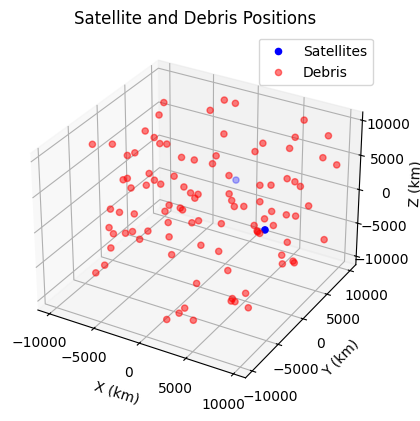

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Plot satellite and debris positions
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

# Plot satellites
ax.scatter(satellites_df["x"], satellites_df["y"], satellites_df["z"], c="blue", label="Satellites")

# Plot debris
ax.scatter(debris_df["x"], debris_df["y"], debris_df["z"], c="red", label="Debris", alpha=0.5)

ax.set_xlabel("X (km)")
ax.set_ylabel("Y (km)")
ax.set_zlabel("Z (km)")
ax.legend()
plt.title("Satellite and Debris Positions")
plt.show()

In [5]:
from sklearn.preprocessing import StandardScaler

# Normalize satellite and debris data
scaler = StandardScaler()
satellites_normalized = scaler.fit_transform(satellites_df[["x", "y", "z", "vx", "vy", "vz"]])
debris_normalized = scaler.transform(debris_df[["x", "y", "z", "vx", "vy", "vz"]])

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Create features (e.g., relative distance, velocity)
def create_features(satellites, debris):
    features = []
    for _, sat in satellites.iterrows():
        sat_pos = sat[["x", "y", "z"]].values
        sat_vel = sat[["vx", "vy", "vz"]].values
        for _, deb in debris.iterrows():
            deb_pos = deb[["x", "y", "z"]].values
            deb_vel = deb[["vx", "vy", "vz"]].values
            rel_distance = np.linalg.norm(sat_pos - deb_pos)
            rel_velocity = np.linalg.norm(sat_vel - deb_vel)
            features.append([rel_distance, rel_velocity])
    return np.array(features)

# Generate features and labels (1 for collision, 0 for no collision)
X = create_features(satellites_df, debris_df)
y = np.random.randint(0, 2, size=len(X))  # Replace with real labels

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest model
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Evaluate the model
accuracy = model.score(X_test, y_test)
print(f"Model Accuracy: {accuracy:.2f}")

Model Accuracy: 0.50


In [8]:
!pip install stable-baselines3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 83.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 68.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 55.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-c

In [9]:
!pip install gym

In [10]:
import gym
from stable_baselines3 import PPO

print("Libraries imported successfully!")

Libraries imported successfully!


In [12]:
!pip install 'shimmy>=2.0'

In [13]:
!pip install gymnasium

In [14]:
import gymnasium as gym  # Use gymnasium instead of gym
from stable_baselines3 import PPO
import numpy as np

# Create a custom environment for satellite trajectory optimization
class SatelliteEnv(gym.Env):
    def __init__(self):
        super(SatelliteEnv, self).__init__()
        # Define action and observation space
        self.action_space = gym.spaces.Box(low=-1, high=1, shape=(3,))  # Thrust in x, y, z
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(6,))  # Position and velocity

    def reset(self, seed=None, options=None):
        # Reset satellite state
        return np.zeros(6), {}  # Return observation and info (empty dict)

    def step(self, action):
        # Apply action and compute new state
        new_state = np.zeros(6)  # Replace with actual dynamics
        reward = 0  # Compute reward based on collision avoidance and fuel usage
        done = False
        info = {}  # Additional info (optional)
        return new_state, reward, done, False, info  # Gymnasium uses `terminated` and `truncated` instead of `done`

# Create environment
env = SatelliteEnv()

# Train RL model
model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=10000)

print("Training complete!")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 1375 |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 2048 |
-----------------------------
--------------------------------------
| time/                   |          |
|    fps                  | 924      |
|    iterations           | 2        |
|    time_elapsed         | 4        |
|    total_timesteps      | 4096     |
| train/                  |          |
|    approx_kl            | 0.0      |
|    clip_fraction        | 0        |
|    clip_range           | 0.2      |
|    entropy_loss         | -4.26    |
|    explained_variance   | nan      |
|    learning_rate        | 0.0003   |
|    loss                 | 0        |
|    n_updates            | 10       |
|    policy_gradient_loss | 0        |
|    std                  | 1        |
|    value_loss           | 0    